##IMPORT

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import hashlib
import numpy as np

##PATH

In [ ]:
# Path ke dataset
dataset_path = '/content/drive/My Drive/DATASET AKSARA/'

##HITUNG PERSEBARAN DATA

In [ ]:
# Hitung jumlah gambar per sandangan
def count_images_per_label(dataset_path):
    label_counts = {}
    for sandangan in os.listdir(dataset_path):
        sandangan_path = os.path.join(dataset_path, sandangan)
        if os.path.isdir(sandangan_path):
            label_counts[sandangan] = sum([len(files) for _, _, files in os.walk(sandangan_path)])
    return label_counts

In [ ]:
# Hasil perhitungan
label_counts = count_images_per_label(dataset_path)
print("Distribusi gambar per sandangan:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")

Distribusi gambar per sandangan:
e (pepet): 40 gambar
u: 40 gambar
e pepet (baris panjang): 20 gambar
u (baris panjang): 20 gambar
o: 40 gambar
e (taling tarung): 40 gambar
i: 40 gambar
e taling (baris panjang): 20 gambar
o (baris panjang): 20 gambar
i (baris panjang): 20 gambar


<ipython-input-5-2dfec32ae010>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="coolwarm")


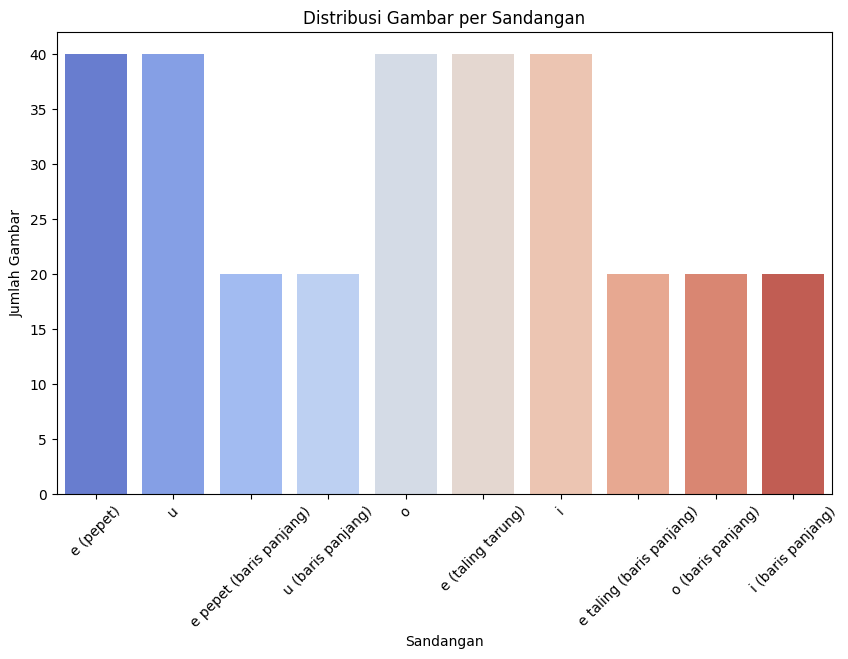

In [ ]:
# Visualisasi distribusi dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="coolwarm")
plt.title("Distribusi Gambar per Sandangan")
plt.xlabel("Sandangan")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

##AUGMENTASI


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Fungsi untuk menampilkan gambar
def show_image(image, title=''):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Fungsi untuk melakukan augmentasi
def augment_image(image, transform):
    augmented = transform(image=image)['image']
    # Konversi tensor ke format numpy array
    augmented = augmented.permute(1, 2, 0).numpy()  # Ubah dimensi (C, H, W) ke (H, W, C)
    augmented = (augmented * 255).astype('uint8')  # Ubah ke format uint8 untuk OpenCV
    return augmented

# Define augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=(-30, 30), p=0.5),
    A.Resize(width=256, height=256),
    ToTensorV2()  # Convert to PyTorch tensor
])

# Path utama dataset
dataset_path = '/content/drive/My Drive/DATASET AKSARA/'

# Iterasi melalui setiap folder sandangan dan abjad
for sandangan in os.listdir(dataset_path):
    sandangan_path = os.path.join(dataset_path, sandangan)
    for abjad in os.listdir(sandangan_path):
        abjad_path = os.path.join(sandangan_path, abjad)

        for image_name in os.listdir(abjad_path):
            image_path = os.path.join(abjad_path, image_name)

            # Baca gambar
            image = cv2.imread(image_path)
            if image is None:
                print(f"File {image_path} is not a valid image.")
                continue

            # Lakukan augmentasi sebanyak 20 kali
            for i in range(20):
                augmented_image = augment_image(image, transform)

                # Simpan gambar hasil augmentasi dengan nama yang berbeda
                augmented_path = os.path.join('/content/drive/My Drive/DATASET AKSARA AUGMENTED/', 'augmented', sandangan, abjad)
                os.makedirs(augmented_path, exist_ok=True)

                # Menambahkan index ke nama file untuk setiap gambar augmented
                augmented_image_name = f"{os.path.splitext(image_name)[0]}_augmented_{i+1}.jpg"
                augmented_image_path = os.path.join(augmented_path, augmented_image_name)

                # Simpan gambar
                cv2.imwrite(augmented_image_path, augmented_image)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Hasil perhitungan
label_counts = count_images_per_label('/content/drive/My Drive/DATASET AKSARA AUGMENTED/')
print("Distribusi gambar per sandangan:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")

Distribusi gambar per sandangan:
augmented: 6000 gambar


##CONTOH GAMBAR

In [ ]:
# Fungsi untuk menampilkan contoh gambar dari folder dataset
def show_sample_images(dataset_path, samples_per_sandangan=2):
    plt.figure(figsize=(15, 10))
    sandangan_list = os.listdir(dataset_path)
    for idx, sandangan in enumerate(sandangan_list):
        sandangan_path = os.path.join(dataset_path, sandangan)
        if os.path.isdir(sandangan_path):  # Pastikan folder
            files = os.listdir(sandangan_path)[:samples_per_sandangan]
            for i, file in enumerate(files):
                img_path = os.path.join(sandangan_path, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(len(sandangan_list), samples_per_sandangan, idx * samples_per_sandangan + i + 1)
                    plt.imshow(img)
                    plt.title(f"{sandangan} - {file}")
                    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan contoh gambar
show_sample_images(dataset_path)

<Figure size 1500x1000 with 0 Axes>

##DETEKSI DUPLIKAT

In [ ]:
# Fungsi untuk membuat hash gambar
def hash_image(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()



In [ ]:
# Deteksi duplikasi
def detect_duplicates(dataset_path):
    hash_set = set()
    duplicates = []
    for sandangan in os.listdir(dataset_path):
        sandangan_path = os.path.join(dataset_path, sandangan)
        if os.path.isdir(sandangan_path):  # Pastikan ini folder
            for file in os.listdir(sandangan_path):
                file_path = os.path.join(sandangan_path, file)
                if os.path.isfile(file_path):  # Pastikan ini file, bukan folder
                    file_hash = hash_image(file_path)
                    if file_hash in hash_set:
                        duplicates.append(file_path)
                    else:
                        hash_set.add(file_hash)
    return duplicates

In [ ]:
# Path ke folder dataset
dataset_path = '/content/drive/My Drive/DATASET AKSARA/'



In [ ]:
# Cek duplikasi
duplicates = detect_duplicates(dataset_path)
print(f"Jumlah gambar duplikat: {len(duplicates)}")
if duplicates:
    print("Daftar gambar duplikat:")
    for dup in duplicates:
        print(dup)

Jumlah gambar duplikat: 0
